# **PandasAI**
PandasAI is a library that makes data analysis conversational and fun again. It leverages the power of pandas dataframes combined to the most advanced LLMs to let users to data analysis in a conversational way.

Let's start!


## **Setup**
To get started, we need to install the last version of PandasAI.

In [43]:
!pip install pandasai

# **SmartDataframe**

A SmartDataframe is a pandas (or polars) dataframe that inherits all the properties and methods from the `pd.DataFrame`, but also adds conversational features to it.

In [44]:
from pandasai import SmartDataframe

You can instantiate a dataframe importing from several different sources (pandas or polars dataframe, csv, xlsx or google sheets).

### **Importing from a pandas dataframe**

To import from a pandas dataframe, you need to import the pandas libraries and create a dataframe first.

In [45]:
import pandas as pd

In [46]:
df = pd.DataFrame({
    "country": [
        "United States",
        "United Kingdom",
        "France",
        "Germany",
        "Italy",
        "Spain",
        "Canada",
        "Australia",
        "Japan",
        "China",
    ],
    "gdp": [
        19294482071552,
        2891615567872,
        2411255037952,
        3435817336832,
        1745433788416,
        1181205135360,
        1607402389504,
        1490967855104,
        4380756541440,
        14631844184064,
    ],
    "happiness_index": [6.94, 7.16, 6.66, 7.07, 6.38, 6.4, 7.23, 7.22, 5.87, 5.12],
})

Since PandasAI is powered by a LLM, you should import the LLM you'd like to use for your use case. In thic case we're gonna use OpenAI.

To use OpenAI, you'll need a API token. Follow below simple steps to generate your API_TOKEN with
[openai](https://platform.openai.com/overview).

1. Go to  https://openai.com/api/ and signup with your email address or connect your Google Account.
2. Go to View API Keys on left side of your Personal Account Settings
3. Select Create new Secret key

> The API access to openai is a paid service. You have to set up billing.
>Read the [Pricing](https://platform.openai.com/docs/quickstart/pricing) information before experimenting.

In [47]:
from pandasai.llm import OpenAI

llm = OpenAI(api_token="YOUR_API_KEY")

Now that we have instantiated the LLM, we can finally instantiate the `SmartDataframe`

In [48]:
sdf = SmartDataframe(df, config={"llm": llm})

You can now query it in natural language

In [49]:
sdf.chat("Return the top 5 countries by GDP")

,country,gdp,happiness_index
0,United States,19294482071552,6.94
9,China,14631844184064,5.12
8,Japan,4380756541440,5.87
3,Germany,3435817336832,7.07
1,United Kingdom,2891615567872,7.16


In [50]:
sdf.chat("What's the sum of the gdp of the 2 unhappiest countries?")

19012600725504

In [51]:
print(sdf.last_code_generated)

data = {'country': ['Japan', 'United Kingdom', 'China'], 'gdp': [1999553663, 182624606, 3310106901], 'happiness_index': [6.94, 5.87, 7.16]}
df = dfs[0]
df_sorted = df.sort_values(by='happiness_index')
sum_gdp_unhappiest = df_sorted.head(2)['gdp'].sum()
result = {'type': 'number', 'value': sum_gdp_unhappiest}


### Plotting a chart

You can also use PandasAI to easily plot a chart

'/content/exports/charts/temp_chart.png'

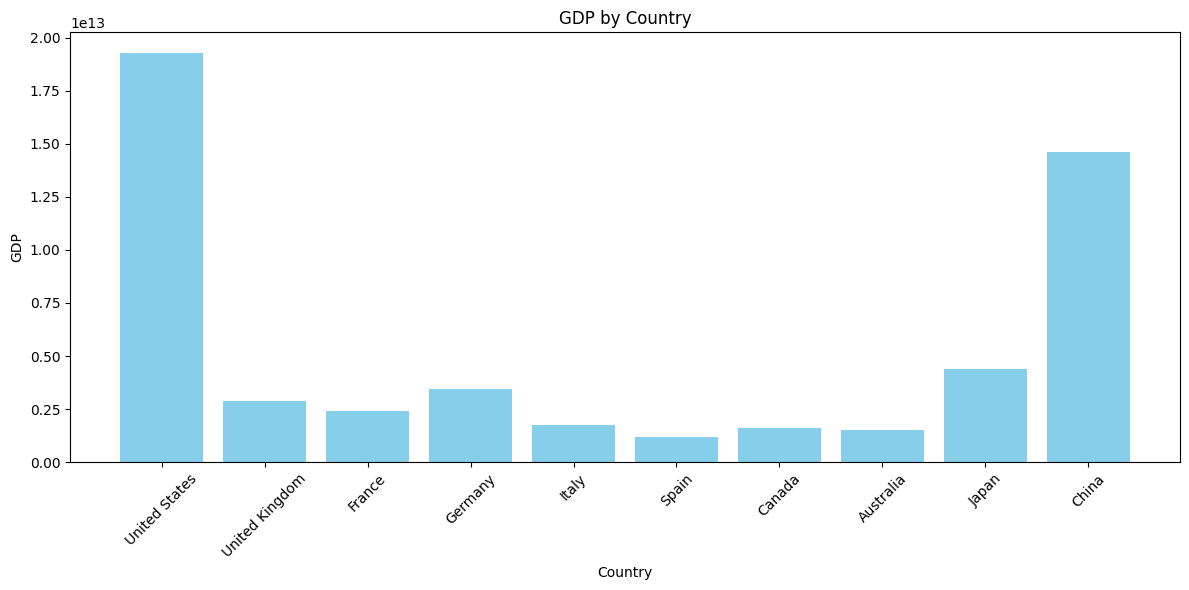

In [52]:
sdf.chat("Plot a chart of the gdp by country")

You can also provide additional instructions. For example, imagine you want to use different colors for each bar. You just need to ask to PandasAI:

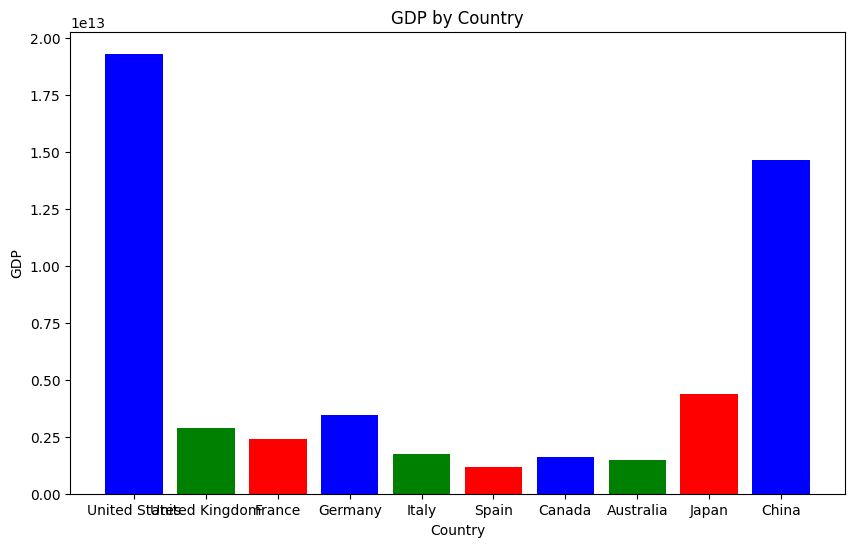

'/content/exports/charts/temp_chart.png'

In [53]:
sdf.chat("Plot a histogram of the gdp by country, using a different color for each bar")

# SmartDatalake

Sometimes, you might want to work with multiple dataframes at a time, letting the LLM orchestrate which one(s) to use to answer your queries. In such cases, instead of using a `SmartDataframe` you should rather use a `SmartDatalake`.

The concept is very similar to the `SmartDataframe`, but instead of accepting only 1 df as input, it can accept multiple ones.

In [54]:
from pandasai import SmartDatalake

For example, in this example, we are provided with 2 different dfs.
In the first one, it's reported for each employee, an employee id, a name and a department.
In the second one, instad, it's provided the employee id and the salary for each employee.

Asking PandasAI, it will join the 2 different dataframes by id and figure out the name of the one that is paid the most.

In [55]:
employees_df = pd.DataFrame(
    {
        "EmployeeID": [1, 2, 3, 4, 5],
        "Name": ["John", "Emma", "Liam", "Olivia", "William"],
        "Department": ["HR", "Sales", "IT", "Marketing", "Finance"],
    }
)

salaries_df = pd.DataFrame(
    {
        "EmployeeID": [1, 2, 3, 4, 5],
        "Salary": [5000, 6000, 4500, 7000, 5500],
    }
)

lake = SmartDatalake(
    [employees_df, salaries_df],
    config={"llm": llm}
)
lake.chat("Who gets paid the most?")

'The employee with the highest salary is Olivia with a salary of 7000.'

Here's an example of the code that is generated:

In [56]:
print(lake.last_code_executed)

highest_salary = max(dfs[1]['Salary'])
result = {'type': 'string', 'value': f"The employee with the highest salary is {dfs[0]['Name'][dfs[1]['Salary'].idxmax()]} with a salary of {highest_salary}."}


Ok in this case it was easy: both the tables are share a common value called `EmployeeID`, right?

Let's try with something more complex

In [57]:
users_df = pd.DataFrame(
    {
        "id": [1, 2, 3, 4, 5],
        "name": ["John", "Emma", "Liam", "Olivia", "William"]
    }
)
users = SmartDataframe(users_df, name="users")

photos_df = pd.DataFrame(
    {
        "id": [31, 32, 33, 34, 35],
        "user_id": [1, 1, 2, 4, 5]
    }
)
photos = SmartDataframe(photos_df, name="photos")

lake = SmartDatalake([users, photos], config={"llm": llm})
lake.chat("How many photos has been uploaded by John?")

1

In this case we provided for each df a table name, so that the LLM has some context and can better perform the joins. As you can see on the example below, it succeeded at figuring out the right join to do. In fact, the user "John" has actually 2 photos.

In [58]:
print(lake.last_code_executed)

john_df = None
for df in dfs:
    if 'name' in df.columns and 'id' in df.columns:
        john_df = df[df['name'] == 'John']
        break
num_photos_uploaded = len(john_df) if john_df is not None else 0
result = {'type': 'number', 'value': num_photos_uploaded}
